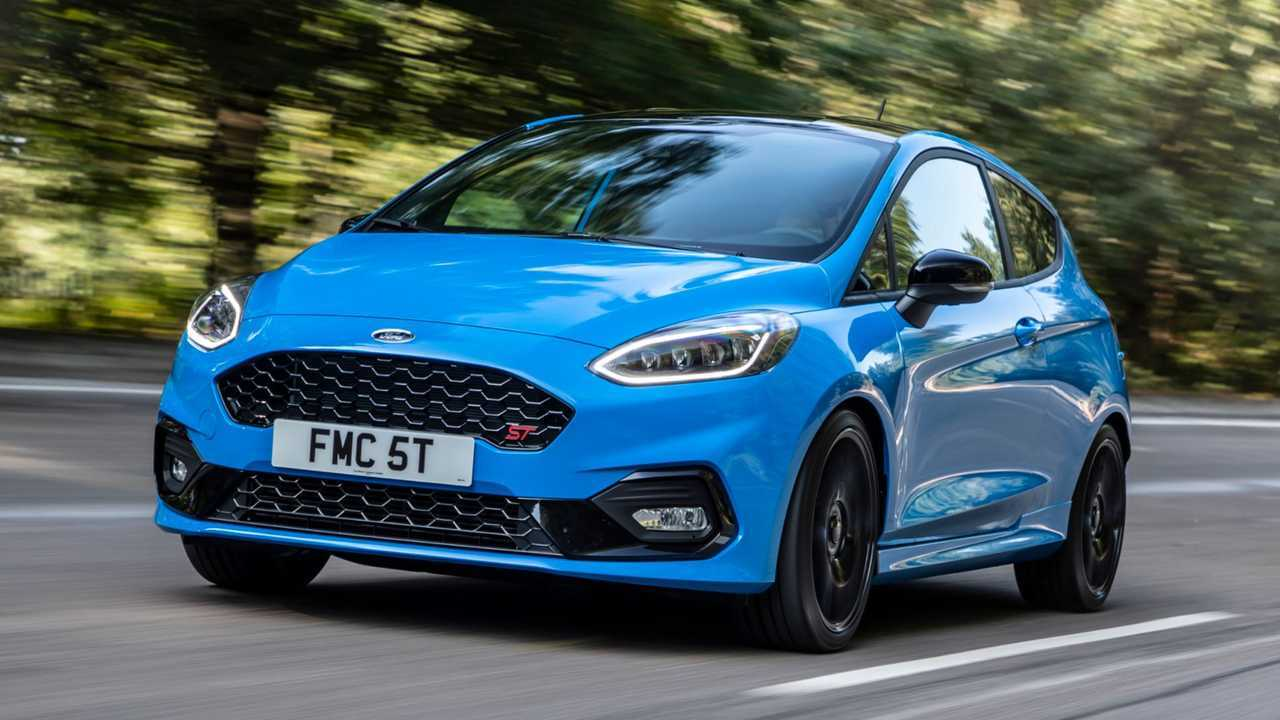


<div style="background-color: navy; padding: 10px; border-radius: 10px;">
    <p style="color: white; font-size: 15px; font-weight: bold;">
        Import Libraries
   </p>
</div>


In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch
import torchvision
from torch.utils.data import DataLoader, TensorDataset
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings ('ignore')


<div style="background-color: navy; padding: 10px; border-radius: 10px;">
    <p style="color: white; font-size: 15px; font-weight: bold;">
        Data
   </p>
</div>


In [2]:
df = pd.read_csv("/kaggle/input/used-car-dataset-ford-and-mercedes/ford.csv")

In [3]:
df.head().T

,0,1,2,3,4
model,Fiesta,Focus,Focus,Fiesta,Fiesta
year,2017,2018,2017,2019,2019
price,12000,14000,13000,17500,16500
transmission,Automatic,Manual,Manual,Manual,Automatic
mileage,15944,9083,12456,10460,1482
fuelType,Petrol,Petrol,Petrol,Petrol,Petrol
tax,150,150,150,145,145
mpg,57.7,57.7,57.7,40.3,48.7
engineSize,1.0,1.0,1.0,1.5,1.0



<div style="background-color: navy; padding: 10px; border-radius: 10px;">
    <p style="color: white; font-size: 15px; font-weight: bold;">
        Data Exploration
   </p>
</div>


In [4]:
def column_summary(df):
    summary_data = []
    
    for col_name in df.columns:
        col_dtype = df[col_name].dtype
        num_of_nulls = df[col_name].isnull().sum()
        num_of_non_nulls = df[col_name].notnull().sum()
        num_of_distinct_values = df[col_name].nunique()
        
        if num_of_distinct_values <= 10:
            distinct_values_counts = df[col_name].value_counts().to_dict()
        else:
            top_10_values_counts = df[col_name].value_counts().head(10).to_dict()
            distinct_values_counts = {k: v for k, v in sorted(top_10_values_counts.items(), key=lambda item: item[1], reverse=True)}

        summary_data.append({
            'col_name': col_name,
            'col_dtype': col_dtype,
            'num_of_nulls': num_of_nulls,
            'num_of_non_nulls': num_of_non_nulls,
            'num_of_distinct_values': num_of_distinct_values,
            
        })
    
    summary_df = pd.DataFrame(summary_data)
    return summary_df


summary_df = column_summary(df)
display(summary_df)

,col_name,col_dtype,num_of_nulls,num_of_non_nulls,num_of_distinct_values
0,model,object,0,17965,23
1,year,int64,0,17965,23
2,price,int64,0,17965,3511
3,transmission,object,0,17965,3
4,mileage,int64,0,17965,13528
5,fuelType,object,0,17965,5
6,tax,int64,0,17965,35
7,mpg,float64,0,17965,90
8,engineSize,float64,0,17965,16


**Univariate Analysis**

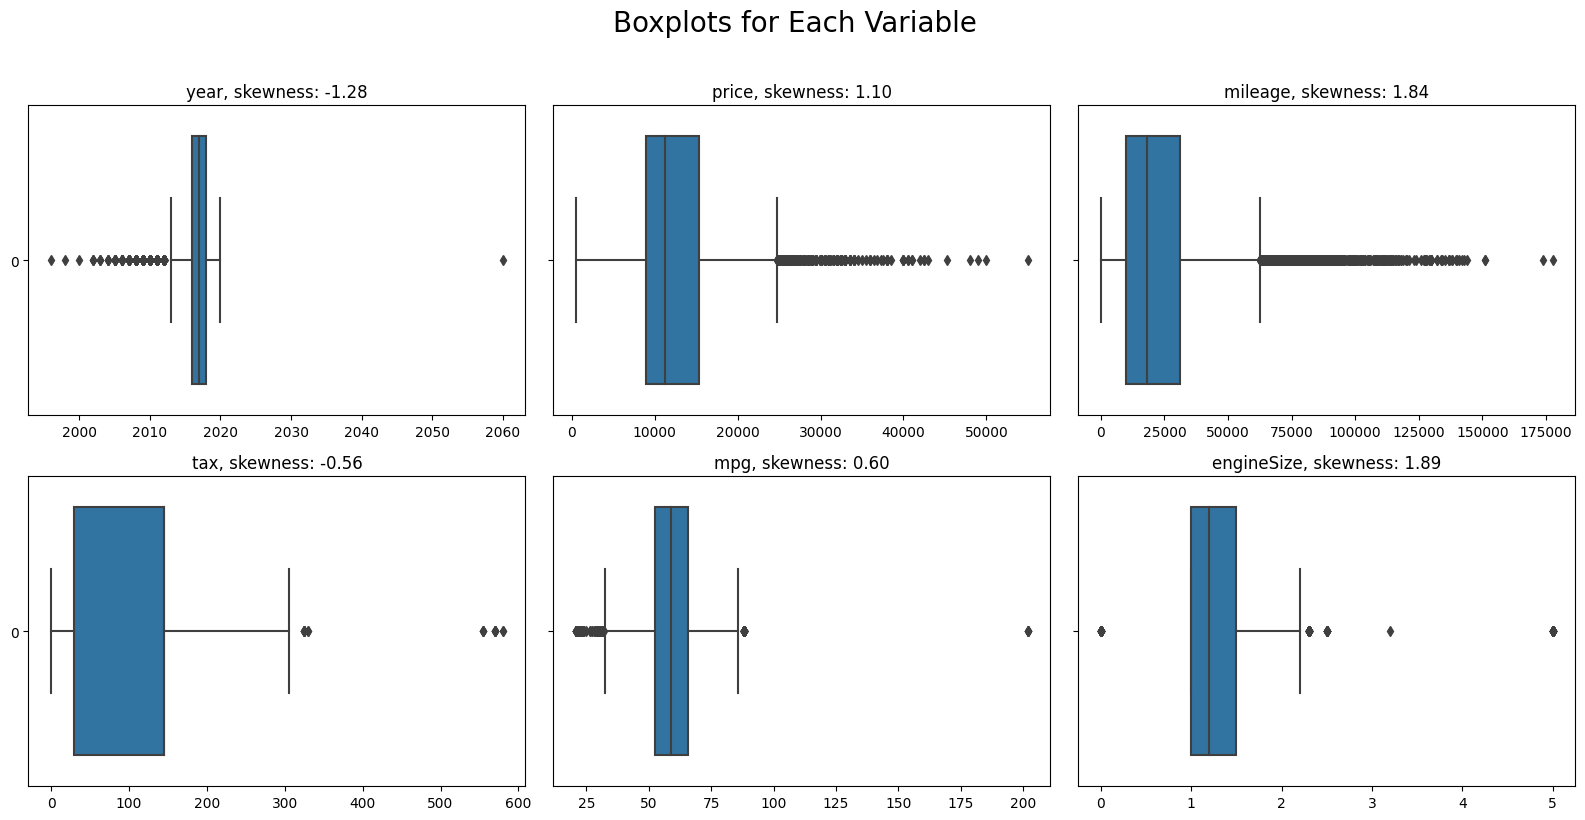

In [5]:
numerical_columns = ['year', 'price', 'mileage', 'tax', 'mpg', 'engineSize']

def univariate_analysis_num(dataset, columns_list, rows, cols, suptitle):
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(16, 8))  
    fig.suptitle(suptitle, y=1.02, size=20)
    axs = axs.flatten()
    for i, column in enumerate(columns_list):
        sns.boxplot(data=dataset[column], orient='h', ax=axs[i])
        skewness = dataset[column].skew(axis=0, skipna=True)
        axs[i].set_title(f'{column}, skewness: {skewness:.2f}')
    plt.tight_layout()
    plt.show()

univariate_analysis_num(dataset=df, columns_list=numerical_columns, rows=2, cols=3, suptitle='Boxplots for Each Variable')


Univariate analysis for transmission column:


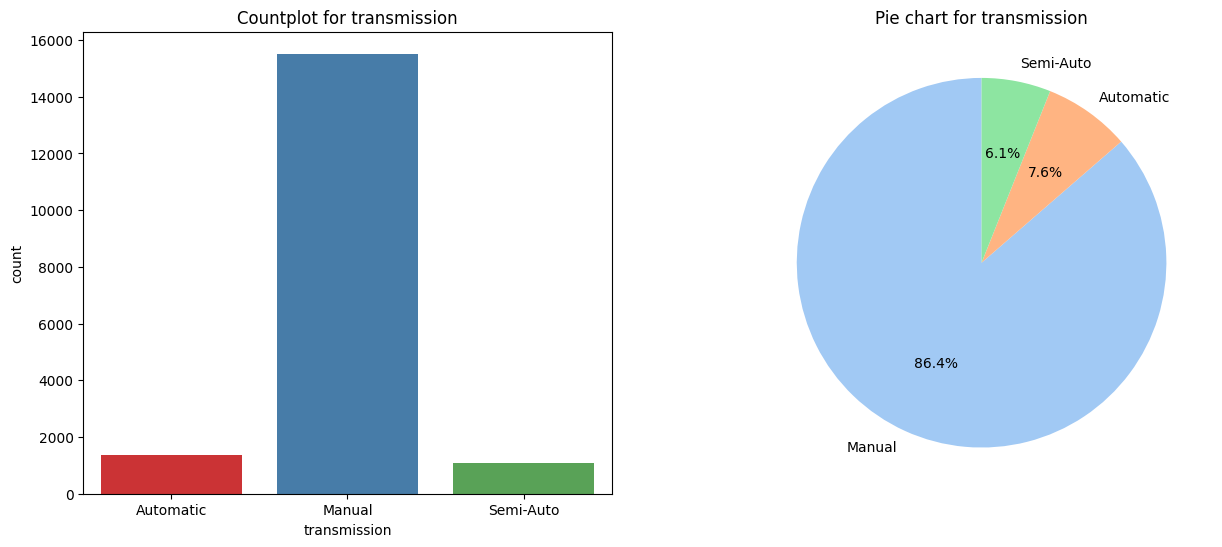

Univariate analysis for fuelType column:


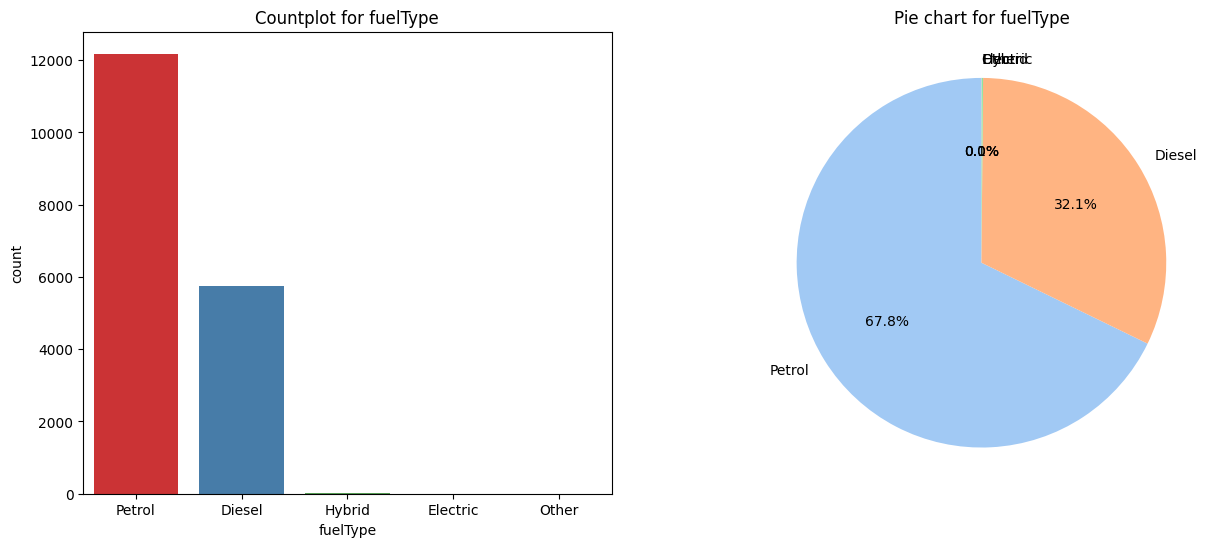

In [6]:
def univariate_analysis_cat(df, col):
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    
    sns.countplot(data=df, x=col, palette='Set1', ax=ax[0])
    ax[0].set_title(f'Countplot for {col}')
    
    data_counts = df[col].value_counts()
    ax[1].pie(data_counts, labels=data_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
    ax[1].set_title(f'Pie chart for {col}')
    
    plt.show()

categorical_cols = ['transmission', 'fuelType']

for col in categorical_cols:
    print(f'Univariate analysis for {col} column:')
    univariate_analysis_cat(df, col)


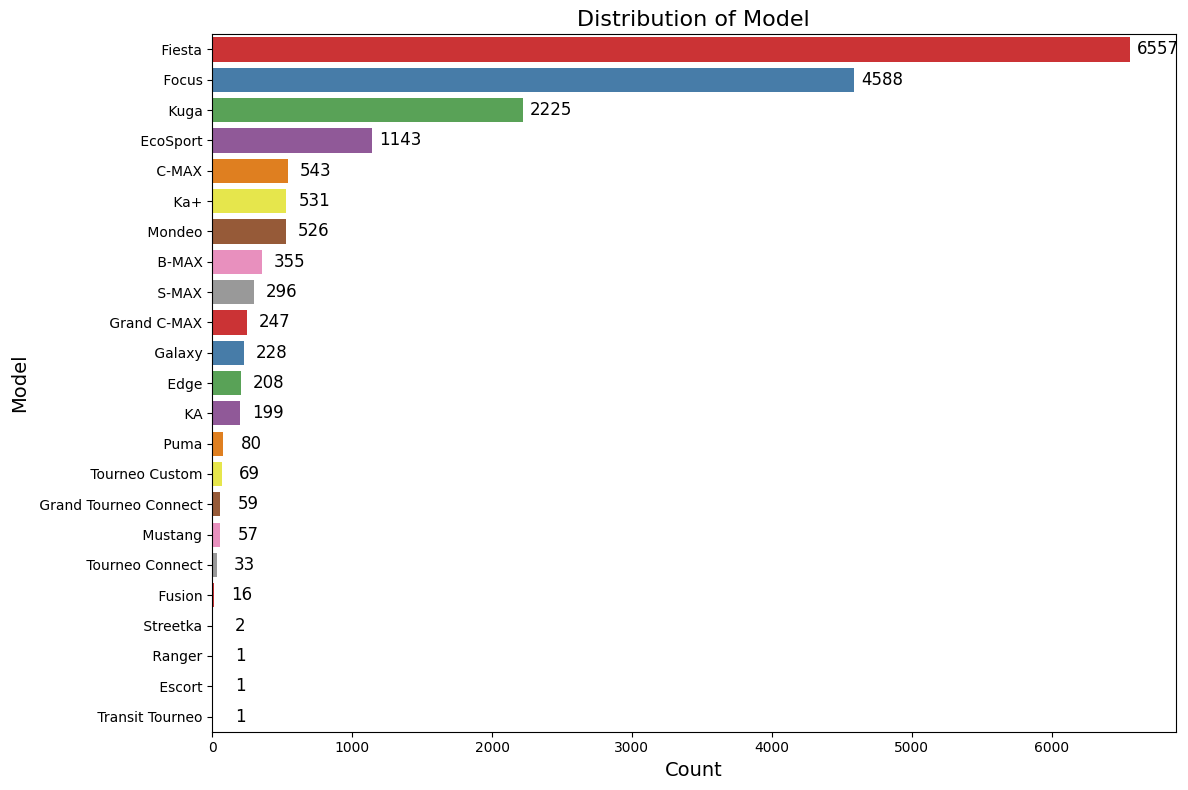

In [7]:
def plot_model_barchart(df, col):
    plt.figure(figsize=(12, 8))
    ax = sns.countplot(data=df, y=col, palette='Set1', order=df[col].value_counts().index)
    ax.set_title(f'Distribution of {col.capitalize()}', fontsize=16)
    ax.set_xlabel('Count', fontsize=14)
    ax.set_ylabel(f'{col.capitalize()}', fontsize=14)
    
    for p in ax.patches:
        ax.annotate(f'{p.get_width():.0f}', (p.get_width(), p.get_y() + p.get_height() / 2),
                    ha='center', va='center', xytext=(20, 0), textcoords='offset points', fontsize=12, color='black')

    plt.tight_layout()
    plt.show()

model_col = 'model'

plot_model_barchart(df, model_col)


**Bivariate Analysis**

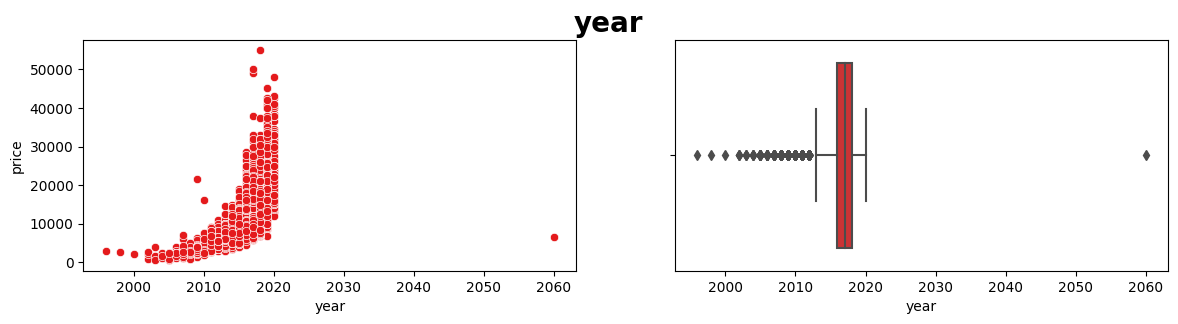

In [8]:
x = 'year'

fig = plt.figure(figsize=(14, 3))
sns.set_palette("Set1")
plt.suptitle(x, size=20, weight='bold')

plt.subplot(1, 2, 1)
sns.scatterplot(x=x, y='price', data=df)

plt.subplot(1, 2, 2)
ax = sns.boxplot(x=x, data=df)


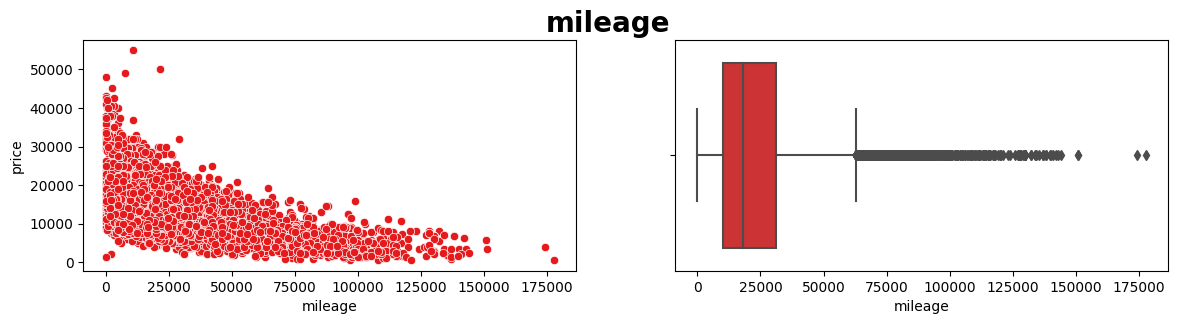

In [9]:
x = 'mileage'

fig = plt.figure(figsize=(14, 3))
sns.set_palette("Set1")
plt.suptitle(x, size=20, weight='bold')

plt.subplot(1, 2, 1)
sns.scatterplot(x=x, y='price', data=df)

plt.subplot(1, 2, 2)
ax = sns.boxplot(x=x, data=df)

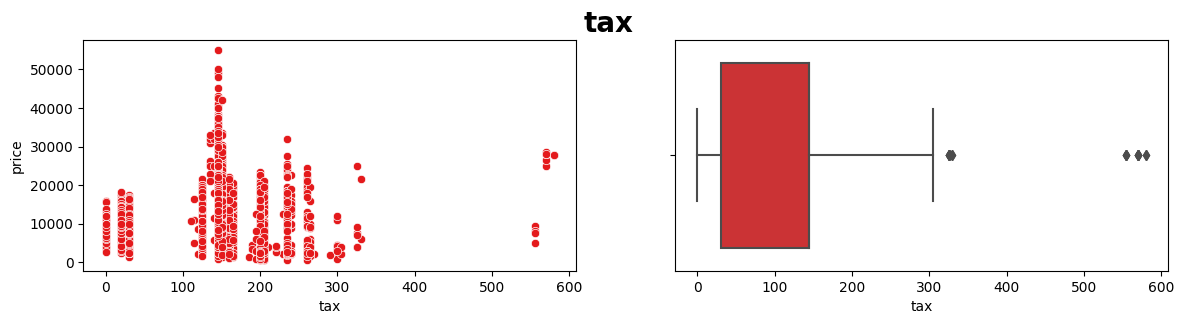

In [10]:
x = 'tax'

fig = plt.figure(figsize=(14, 3))
sns.set_palette("Set1")
plt.suptitle(x, size=20, weight='bold')

plt.subplot(1, 2, 1)
sns.scatterplot(x=x, y='price', data=df)

plt.subplot(1, 2, 2)
ax = sns.boxplot(x=x, data=df)


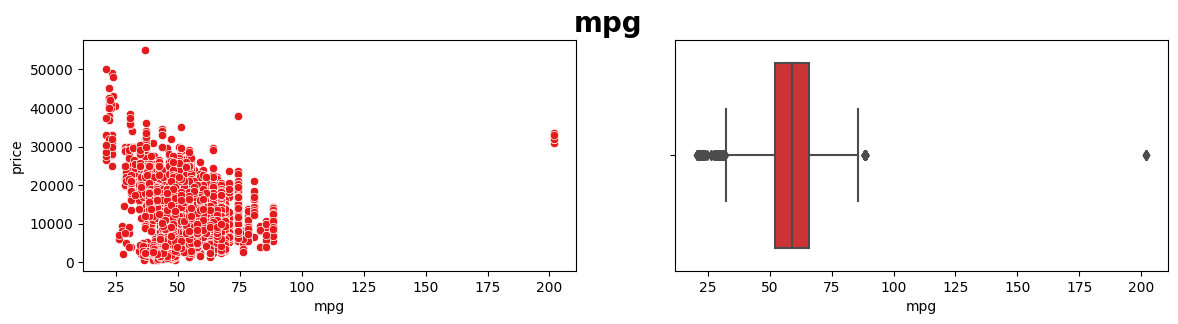

In [11]:
x = 'mpg'

fig = plt.figure(figsize=(14, 3))
sns.set_palette("Set1")
plt.suptitle(x, size=20, weight='bold')

plt.subplot(1, 2, 1)
sns.scatterplot(x=x, y='price', data=df)

plt.subplot(1, 2, 2)
ax = sns.boxplot(x=x, data=df)

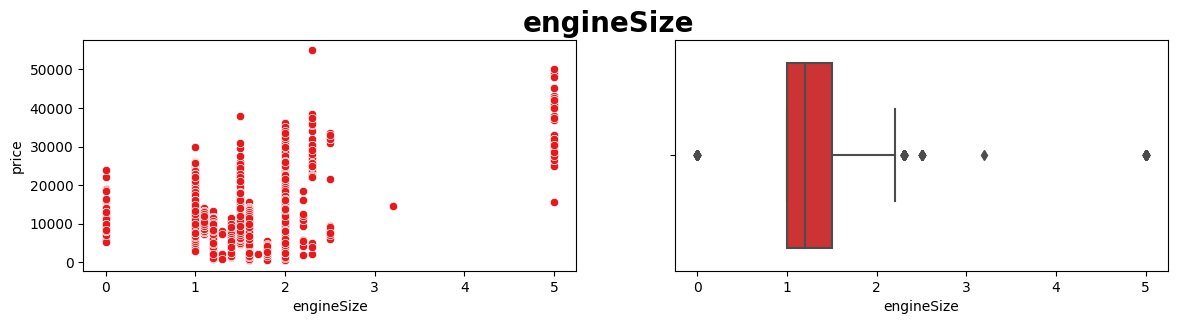

In [12]:
x = 'engineSize'

fig = plt.figure(figsize=(14, 3))
sns.set_palette("Set1")
plt.suptitle(x, size=20, weight='bold')

plt.subplot(1, 2, 1)
sns.scatterplot(x=x, y='price', data=df)

plt.subplot(1, 2, 2)
ax = sns.boxplot(x=x, data=df)

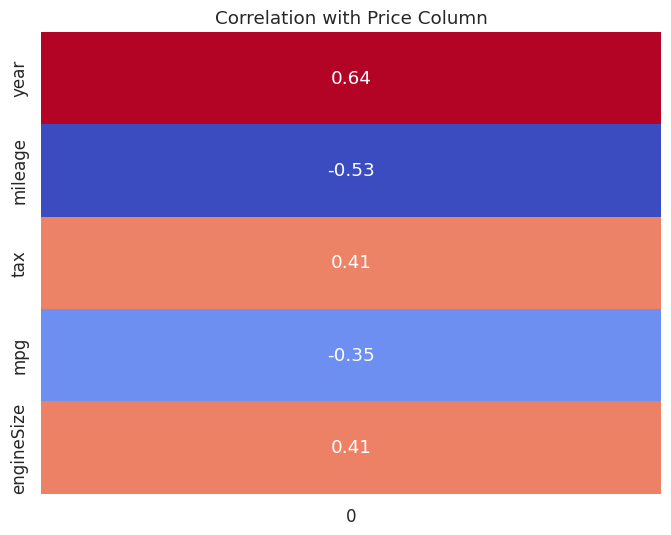

In [13]:
selected_columns = ['year','mileage', 'tax', 'mpg', 'engineSize']
target_corr = df[selected_columns].corrwith(df['price'])

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.1)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr.to_frame(), cmap="coolwarm", annot=True, fmt='.2f', cbar=False)
plt.title('Correlation with Price Column')
plt.show()


<div style="background-color: navy; padding: 10px; border-radius: 10px;">
    <p style="color: white; font-size: 15px; font-weight: bold;">
        Data Preprocessing
   </p>
</div>


In [14]:
df1 = df.copy()

In [15]:
label_encoders = {}
for column in ['model', 'transmission', 'fuelType']:
    le = LabelEncoder()
    df1[column] = le.fit_transform(df[column])
    label_encoders[column] = le


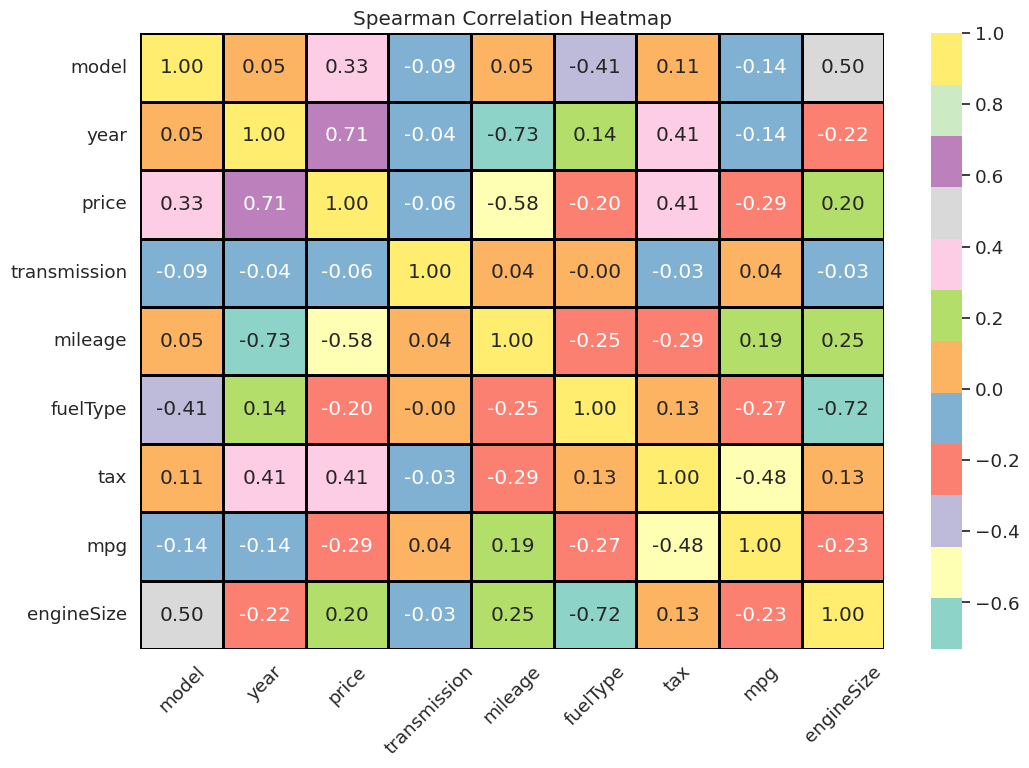

In [16]:
spearman_corr = df1.corr(method='spearman')

plt.figure(figsize=(12, 8))
sns.set(font_scale=1.2)
sns.heatmap(spearman_corr, annot=True, cmap='Set3', fmt=".2f", linewidths=1, linecolor='black')
plt.title('Spearman Correlation Heatmap')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [17]:
X = df1.drop(columns=['price'])
y = df1['price']


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
robust_scaler = RobustScaler()
X_train_robust = robust_scaler.fit_transform(X_train)
X_test_robust = robust_scaler.transform(X_test)

standard_scaler = StandardScaler()
X_train_standard = standard_scaler.fit_transform(X_train)
X_test_standard = standard_scaler.transform(X_test)


In [20]:
X_scaled_df = pd.DataFrame(X_train_robust, columns=X_train.columns)  

X_scaled_df.describe().T.style.background_gradient(axis=0, cmap='Set3')

,count,mean,std,min,25%,50%,75%,max
model,14372.000000,0.409268,1.998054,-3.000000,-0.500000,0.000000,0.500000,8.000000
year,14372.000000,-0.061091,1.016730,-10.500000,-0.500000,0.000000,0.500000,21.500000
transmission,14372.000000,-0.014820,0.368346,-1.000000,0.000000,0.000000,0.000000,1.000000
mileage,14372.000000,0.240482,0.923298,-0.868269,-0.394728,0.000000,0.605272,7.402726
fuelType,14372.000000,-0.321528,0.466753,-1.000000,-1.000000,0.000000,0.000000,0.000000
tax,14372.000000,-0.275841,0.540651,-1.260870,-1.000000,0.000000,0.000000,3.782609
mpg,14372.000000,-0.069860,0.759366,-2.843284,-0.492537,0.000000,0.507463,10.664179
engineSize,14372.000000,0.300960,0.874807,-2.400000,-0.400000,0.000000,0.600000,7.600000



<div style="background-color: navy; padding: 10px; border-radius: 10px;">
    <p style="color: white; font-size: 15px; font-weight: bold;">
        Model Building
   </p>
</div>


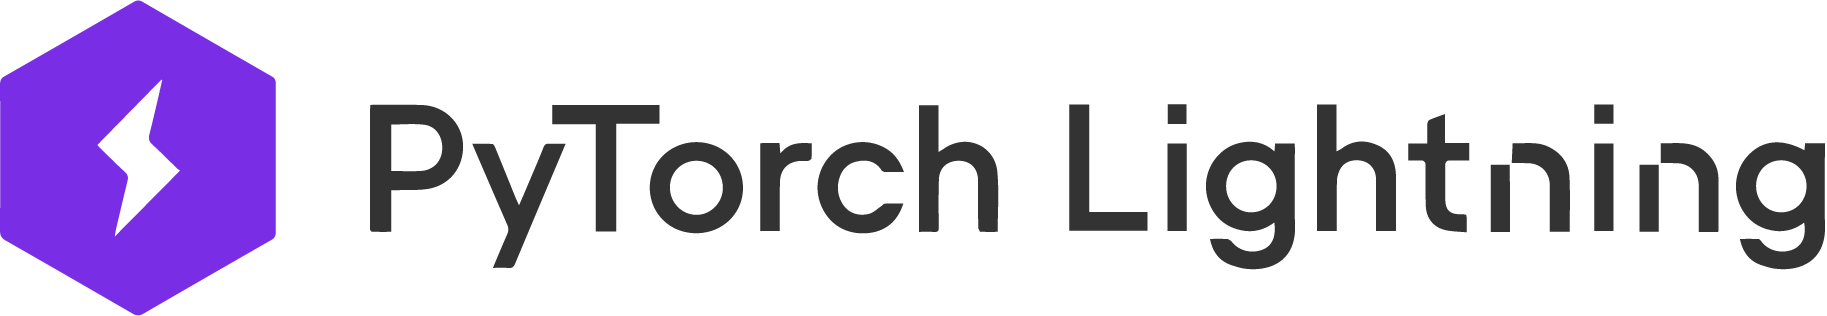

In [21]:
class RegressionModel(pl.LightningModule):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.layer_1 = torch.nn.Linear(input_dim, 128)
        self.layer_2 = torch.nn.Linear(128, 64)
        self.layer_3 = torch.nn.Linear(64, 1)
        self.criterion = torch.nn.MSELoss()
    
    def forward(self, x):
        x = torch.relu(self.layer_1(x))
        x = torch.relu(self.layer_2(x))
        x = self.layer_3(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.criterion(y_hat, y)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.criterion(y_hat, y)
        self.log('val_loss', loss)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

train_dataset = TensorDataset(torch.tensor(X_train_standard, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1))
test_dataset = TensorDataset(torch.tensor(X_test_standard, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)



In [22]:
model = RegressionModel(input_dim=X_train.shape[1])
trainer = pl.Trainer(max_epochs=50)
trainer.fit(model, train_loader, test_loader)

2024-05-22 05:02:27.586270: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-22 05:02:27.586405: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-22 05:02:27.870694: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


<div style="background-color: navy; padding: 10px; border-radius: 10px;">
    <p style="color: white; font-size: 15px; font-weight: bold;">
       Model Evaluation
   </p>
</div>


In [23]:
model.eval()
predictions, actuals = [], []
with torch.no_grad():
    for batch in test_loader:
        x, y = batch
        y_hat = model(x)
        predictions.extend(y_hat.view(-1).tolist())
        actuals.extend(y.view(-1).tolist())

In [24]:
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(actuals, predictions)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R²: {r2}')


MSE: 3772073.3952112384
RMSE: 1942.182636934858
R²: 0.8314408365855218


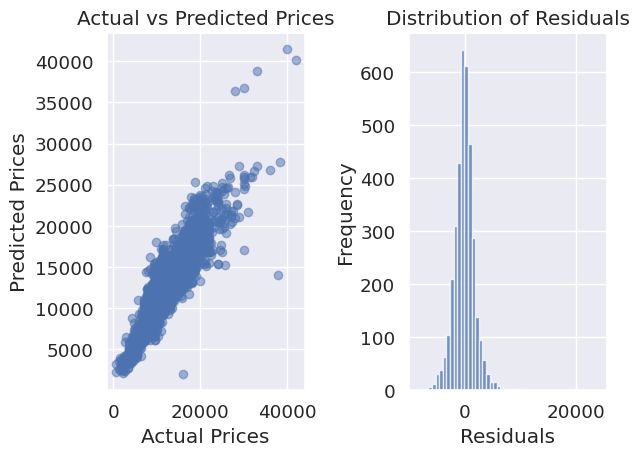

In [25]:
plt.subplot(1, 2, 1)
plt.scatter(actuals, predictions, alpha=0.5)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')

residuals = np.array(actuals) - np.array(predictions)
plt.subplot(1, 2, 2)
plt.hist(residuals, bins=50, alpha=0.75)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')

plt.tight_layout()
plt.show()


<div style="background-color: navy; padding: 10px; border-radius: 10px;">
    <p style="color: white; font-size: 15px; font-weight: bold;">
       Reporting
   </p>
</div>


In [26]:
submission = pd.DataFrame({'Actual': actuals, 'Predicted': predictions})
submission.to_csv('submission.csv', index=False)


In [27]:
submission.head()

,Actual,Predicted
0,12495.0,15908.918945
1,8999.0,9511.726562
2,7998.0,8039.455078
3,5491.0,7708.602539
4,3790.0,4326.370117


<div style="background-color: navy; padding: 10px; border-radius: 10px;">
    <p style="color: white; font-size: 15px; font-weight: bold;">
       Finish
   </p>
</div>

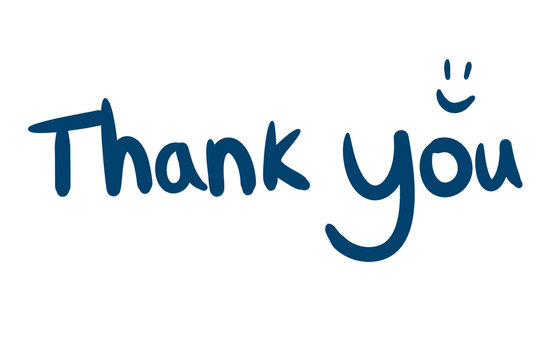